In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

from torch.utils.data import Dataset
from PIL import Image
import os
import torch

class SequenceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        
        for subfolder in ['1', '2', '4', '8']:
        # for subfolder in ['1']:
        # for subfolder in ['8']:
            subfolder_path = os.path.join(self.root_dir, subfolder)
            for sequence_folder in os.listdir(subfolder_path):
                sequence_path = os.path.join(subfolder_path, sequence_folder)
                images = [os.path.join(sequence_path, img) for img in sorted(os.listdir(sequence_path))]

                # Extract label from the file name (assuming all images in a sequence have the same label)
                label_from_filename = int(images[-1].split('_')[-1].split('.')[0])  # Extract the '15' from 'cue_4_15.png'
                self.data.append(images)
                self.labels.append(label_from_filename//15)  # Use the extracted label directly

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_paths = self.data[idx]
        images = [Image.open(img_path) for img_path in image_paths]
        if self.transform:
            images = [self.transform(img) for img in images]
        images = torch.stack(images, dim=0)  # Stack the images to create a tensor of shape (30, C, H, W)
        label = self.labels[idx]
        return images, label

# Set your root directory
root_dir = '../data/delay_match_noise'

# Define any transformations (optional)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset
dataset = SequenceDataset(root_dir=root_dir, transform=transform)

from collections import Counter
from torch.utils.data import WeightedRandomSampler

# Split into training and testing sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_data, vali_data = train_test_split(train_data, test_size=0.25, random_state=42)

# Count the labels in the training data split
train_labels = [label for _, label in train_data]
label_counts = Counter(train_labels)
train_weights = [1.0 / label_counts[label] for _, label in train_data]

# Create a sampler
train_sampler = WeightedRandomSampler(train_weights, num_samples=len(train_weights), replacement=True)
batch_size = 128

# # Create DataLoaders with the sampler for training
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=4)
vali_loader = DataLoader(vali_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

# loader_for_one = DataLoader(train_data, batch_size=batch_size, num_workers=4)
# loader_for_eight = DataLoader(train_data, batch_size=batch_size, num_workers=4)

# print(f"Train set size: {len(train_data)}")
# print(f"Validation set size: {len(vali_data)}")
# print(f"Test set size: {len(test_data)}")

# Example of how to iterate over the DataLoader
# for images, labels in train_loader:
#     print(images.shape)  # Should print something like (16, 30, 3, 224, 224) for a batch of 16
#     print(labels.shape)  # Should print (16,)
#     break


In [2]:
import torch

def create_patch_mask(image_size=64, square_size=10, center_distance=20, stripe_indices=[0, 2, 4, 6], device='cuda'):
    """
    Creates a binary mask for a 256x256 image with 1s at patch positions and 0s elsewhere, using PyTorch GPU tensors.
    Parameters:
        - image_size: Size of the square image (default 256x256).
        - square_size: Size of each patch/square (default 40x40).
        - center_distance: Distance from the image center to each patch center.
        - stripe_indices: List of indices specifying which patches to activate (as per angles).
        - device: The device to store the mask on ('cuda' for GPU).
    Returns:
        - mask: A binary mask with 1s at patch positions and 0s elsewhere, as a PyTorch tensor.
    """
    # Initialize a blank mask on the specified device
    mask = torch.zeros((image_size, image_size), dtype=torch.float32, device=device)

    # Calculate the center of the image
    center_x, center_y = image_size // 2, image_size // 2

    # Angles for positioning the patches
    angles = torch.arange(0, 360, 45, device=device)

    # Place patches in the mask based on stripe_indices
    for idx, square_angle in enumerate(angles):
        if idx in stripe_indices:
            # Calculate the center position for the patch
            radian = torch.deg2rad(square_angle)
            square_center_x = int(center_x + center_distance * torch.cos(radian))
            square_center_y = int(center_y + center_distance * torch.sin(radian))
            
            # Calculate the top-left and bottom-right coordinates of the patch
            top_left_x = square_center_x - square_size // 2
            top_left_y = square_center_y - square_size // 2
            bottom_right_x = square_center_x + square_size // 2
            bottom_right_y = square_center_y + square_size // 2
            
            # Set the region in the mask to 1 for the patch
            mask[top_left_y:bottom_right_y, top_left_x:bottom_right_x] = 1

    return mask

# Example usage
stripe_indices = [0, 1, 2, 3, 4, 5, 6, 7]  # Choose patch indices to focus on
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
mask = create_patch_mask(stripe_indices=stripe_indices, device=device)


In [42]:
import torch
import torch.nn as nn
import torchvision.models as models

class CNN_RNN_Model(nn.Module):
    def __init__(self):
        super(CNN_RNN_Model, self).__init__()
        self.rnn_layers = 2
        self.hidden_size = 256
        self.rnn_input_size = 512
        stripe_indices = [0, 1, 2, 3, 4, 5, 6, 7]
        self.mask = create_patch_mask(stripe_indices=stripe_indices, device=device).unsqueeze(0).unsqueeze(0)
        
        self.cnn = models.resnet18(pretrained=False)
        self.cnn.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.cnn = nn.Sequential(
            *list(self.cnn.children())[:-1],
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.3)
        )
        
        # self.cnn.eval()
        # for param in self.cnn.parameters():
        #     param.requires_grad = False
        
        # Replace LSTM with a vanilla RNN layer
        self.rnn = nn.RNN(input_size=self.rnn_input_size, hidden_size=self.hidden_size, num_layers=self.rnn_layers, batch_first=True, dropout=0.3)
        
        # Output layer
        self.fc = nn.Linear(self.hidden_size, 12)

    def forward(self, x, hidden=None, masking=True):
        if hidden is None:
            h_0 = torch.zeros(self.rnn_layers, x.size(0), self.rnn.hidden_size).to(x.device)
            hidden = h_0
        
        if masking:
            if (self.mask.shape[0] != x.size(0)) or (self.mask.shape[1] != x.size(1)):
                self.mask = mask.expand(x.size(0), x.size(1), -1, -1)
                
            x = x * self.mask 
        
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = x.unsqueeze(1)  # Add a dimension for time step (e.g., (batch_size, time_steps, features))
        
        # Stack CNN features and feed to RNN
        rnn_out, hidden = self.rnn(x, hidden)
        
        # Classification
        output = self.fc(rnn_out[:, -1, :])  # Take the output from the last RNN time step
        
        return output, hidden


In [8]:
import torch
import torch.nn as nn
import torchvision.models as models

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNN_RNN_Model(nn.Module):
    def __init__(self):
        super(CNN_RNN_Model, self).__init__()
        self.rnn_layers = 2
        self.hidden_size = 16
        self.rnn_input_size = 512
        stripe_indices = [0, 1, 2, 3, 4, 5, 6, 7]
        self.mask = create_patch_mask(stripe_indices=stripe_indices, device=device).unsqueeze(0).unsqueeze(0)
        
        self.cnn = models.resnet18(pretrained=False)
        self.cnn.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.cnn = nn.Sequential(
            *list(self.cnn.children())[:-1],
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.3)
        )
        
        # self.cnn.eval()
        # for param in self.cnn.parameters():
        #     param.requires_grad = False
        
        self.rnn = nn.LSTM(input_size=self.rnn_input_size, hidden_size=self.hidden_size, num_layers=self.rnn_layers, batch_first=True, dropout=0.3, bidirectional=False)
        self.fc = nn.Linear(self.hidden_size, 12)  # Output layer for binary classification (change or no change)

    def forward(self, x, hidden=None, masking=True):
        if hidden is None:
            h_0 = torch.zeros(self.rnn_layers, x.size(0), self.rnn.hidden_size).to(x.device)
            c_0 = torch.zeros(self.rnn_layers, x.size(0), self.rnn.hidden_size).to(x.device)
            hidden = (h_0, c_0)
        
        if masking:
            if (self.mask.shape[0] != x.size(0)) or (self.mask.shape[1] != x.size(1)):
                self.mask = mask.expand(x.size(0), x.size(1), -1, -1) 
                
            x = x * self.mask 
            
        x = self.cnn(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = x.unsqueeze(1)
        
        # Stack CNN features and feed to RNN
        rnn_out, hidden = self.rnn(x, hidden)
        # print(rnn_out.shape)
        
        # Classification
        output = self.fc(rnn_out[:, -1, :])  # Take the output from the last RNN time step
        
        return output, hidden


In [44]:
import torch
import torch.nn as nn
import torchvision.models as models

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CTRNN(nn.Module):
    def __init__(self, input_size, hidden_size, tau=0.1):
        super(CTRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau  # Time constant for continuous time dynamics
        
        # Weight matrices
        self.W = nn.Parameter(torch.randn(input_size, hidden_size))  # Input weights
        self.U = nn.Parameter(torch.randn(hidden_size, hidden_size))  # Recurrent weights
        self.b = nn.Parameter(torch.zeros(hidden_size))  # Bias term
        self.activation = nn.Tanh()  # Activation function

    def forward(self, x, h_prev, dt=1.0):
        # Compute the continuous time dynamics using Euler's method
        h_dot = -h_prev + self.activation(torch.matmul(x, self.W) + torch.matmul(h_prev, self.U) + self.b)
        h_next = h_prev + h_dot * dt / self.tau  # Euler integration step
        return h_next

class CNN_CTRNN_Model(nn.Module):
    def __init__(self):
        super(CNN_CTRNN_Model, self).__init__()
        self.hidden_size = 24
        self.rnn_input_size = 512
        stripe_indices = [0, 1, 2, 3, 4, 5, 6, 7]
        self.mask = create_patch_mask(stripe_indices=stripe_indices, device=device).unsqueeze(0).unsqueeze(0)
        
        # CNN feature extraction part (ResNet)
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.cnn = nn.Sequential(
            *list(self.cnn.children())[:-1],  # Removing the final fully connected layer
            nn.AdaptiveAvgPool2d((1, 1)),  # Pooling to get a feature vector
            nn.Dropout(0.3)
        )
        
        self.cnn.eval()
        for param in self.cnn.parameters():
            param.requires_grad = False
        
        # Continuous Time RNN (CTRNN)
        self.ctrnn = CTRNN(input_size=self.rnn_input_size, hidden_size=self.hidden_size)
        self.fc = nn.Linear(self.hidden_size, 12)  # Final classification layer (adjust output classes)

    def forward(self, x, hidden=None, masking=True):
        # Initialize hidden state if not provided
        if hidden is None:
            hidden = torch.zeros(x.size(0), self.hidden_size).to(x.device)
        
        # Apply the mask if necessary
        if masking:
            if (self.mask.shape[0] != x.size(0)) or (self.mask.shape[1] != x.size(1)):
                self.mask = mask.expand(x.size(0), x.size(1), -1, -1)
            x = x * self.mask  # Apply masking to input
        
        # Pass through the CNN feature extractor
        x = self.cnn(x)  # [batch_size, channels, 1, 1]
        x = x.view(x.size(0), -1)  # Flatten CNN output [batch_size, features]
        x = x.unsqueeze(1)  # Add sequence dimension [batch_size, seq_len=1, features]

        # Apply CTRNN directly (no iteration through time steps, as seq_len=1)
        hidden = self.ctrnn(x.squeeze(1), hidden)  # Squeeze out the time dimension, pass the input once

        # Final classification output: take the last hidden state
        output = self.fc(hidden)  # [batch_size, output_size]
        
        return output, hidden


In [4]:
import torch.nn as nn
import torch.optim as optim

def train(num_epochs=100, model=None, delay_num=0, lr=1e-4):
    # Define the model, loss function, and optimizer
    if model is None:
        model = CNN_RNN_Model().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)
    # many_ones = torch.zeros(batch_size, device='cuda:0')
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        total_train = 0
        correct_train = 0

        # Training loop
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            hidden = None
            loss = 0.0
            
            for i in range(30):
                if 10 + delay_num <= i < 20:
                    continue
                image = images[:, i]
            # for i in range(3):
            #     image = images[:, i*10+2]
                outputs, hidden = model(image, hidden)
            
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = outputs.argmax(-1)
            total_train += images.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        
        model.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0
        total_vali = 0
        correct_vali = 0
        
        with torch.no_grad():  # Turn off gradients for validation
            for images, labels in vali_loader:
                images = images.to(device)
                labels = labels.to(device)

                hidden = None
                
                for i in range(30):
                    if 10 + delay_num <= i < 20:
                        continue
                    image = images[:, i]
                # for i in range(3):
                #     image = images[:, i*10+2]
                    outputs, hidden = model(image, hidden)
                
                val_loss = criterion(outputs, labels.long())
                running_val_loss += val_loss.item()
                predicted = outputs.argmax(-1)
                total_vali += images.size(0)
                correct_vali += (predicted == labels).sum().item()
                # diff = torch.abs(predicted - labels)
                # cyclic_diff = torch.minimum(diff, 12 - diff)
                # correct_vali += ((cyclic_diff == 0).float() * 1.0 + (cyclic_diff == 1).float() * 0.8 + (cyclic_diff == 2).float() * 0.6 + (cyclic_diff == 3).float() * 0.4 + (cyclic_diff == 4).float() * 0.2).sum().item()


        # Calculate average validation loss and accuracy
        epoch_val_loss = running_val_loss / len(vali_loader)
        vali_accuracy = 100 * correct_vali / total_vali
        print(f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {vali_accuracy:.2f}%')

    print('Finished Training')
    return model

In [43]:
# rnn with noise
model = train(200, model=None, delay_num=0)

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/200], Loss: 2.5084, Training Accuracy: 7.88%
Validation Loss: 2.4936, Validation Accuracy: 8.38%
Epoch [2/200], Loss: 2.4997, Training Accuracy: 9.00%
Validation Loss: 2.4833, Validation Accuracy: 10.50%
Epoch [3/200], Loss: 2.4839, Training Accuracy: 9.29%
Validation Loss: 2.4941, Validation Accuracy: 9.38%
Epoch [4/200], Loss: 2.4900, Training Accuracy: 10.08%
Validation Loss: 2.4986, Validation Accuracy: 8.88%
Epoch [5/200], Loss: 2.4940, Training Accuracy: 8.75%
Validation Loss: 2.5015, Validation Accuracy: 9.00%
Epoch [6/200], Loss: 2.4916, Training Accuracy: 8.46%
Validation Loss: 2.4873, Validation Accuracy: 9.62%
Epoch [7/200], Loss: 2.4887, Training Accuracy: 9.54%
Validation Loss: 2.5028, Validation Accuracy: 7.62%
Epoch [8/200], Loss: 2.4902, Training Accuracy: 10.33%
Validation Loss: 2.4949, Validation Accuracy: 9.50%
Epoch [9/200], Loss: 2.4856, Training Accuracy: 9.42%
Validation Loss: 2.4893, Validation Accuracy: 7.25%
Epoch [10/200], Loss: 2.4826, Training Accu

KeyboardInterrupt: 

In [45]:
# ctrnn with noise
model = train(100, model=None, delay_num=0)

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/100], Loss: 2.5087, Training Accuracy: 9.00%
Validation Loss: 2.4975, Validation Accuracy: 8.38%
Epoch [2/100], Loss: 2.5016, Training Accuracy: 7.79%
Validation Loss: 2.4902, Validation Accuracy: 8.12%
Epoch [3/100], Loss: 2.4965, Training Accuracy: 9.17%
Validation Loss: 2.4902, Validation Accuracy: 9.12%
Epoch [4/100], Loss: 2.4959, Training Accuracy: 10.38%
Validation Loss: 2.4935, Validation Accuracy: 9.25%
Epoch [5/100], Loss: 2.4922, Training Accuracy: 10.29%
Validation Loss: 2.4947, Validation Accuracy: 8.25%
Epoch [6/100], Loss: 2.4978, Training Accuracy: 8.71%
Validation Loss: 2.4974, Validation Accuracy: 8.50%
Epoch [7/100], Loss: 2.4984, Training Accuracy: 9.88%
Validation Loss: 2.4895, Validation Accuracy: 9.62%
Epoch [8/100], Loss: 2.4832, Training Accuracy: 11.00%
Validation Loss: 2.4892, Validation Accuracy: 10.12%
Epoch [9/100], Loss: 2.4846, Training Accuracy: 10.12%
Validation Loss: 2.5110, Validation Accuracy: 6.88%
Epoch [10/100], Loss: 2.4902, Training Ac

In [ ]:
# ctrnn with noise
model = train(100, model=model, delay_num=5)

Epoch [1/50], Loss: 0.9004, Training Accuracy: 79.83%
Validation Loss: 2.3257, Validation Accuracy: 32.38%
Epoch [2/50], Loss: 0.9142, Training Accuracy: 81.38%
Validation Loss: 2.3312, Validation Accuracy: 35.75%
Epoch [3/50], Loss: 0.8638, Training Accuracy: 83.42%
Validation Loss: 2.5160, Validation Accuracy: 30.12%
Epoch [4/50], Loss: 0.8484, Training Accuracy: 82.71%
Validation Loss: 2.3426, Validation Accuracy: 32.00%
Epoch [5/50], Loss: 0.9040, Training Accuracy: 81.96%
Validation Loss: 2.0690, Validation Accuracy: 39.75%
Epoch [6/50], Loss: 0.8571, Training Accuracy: 82.71%
Validation Loss: 2.0903, Validation Accuracy: 39.75%
Epoch [7/50], Loss: 0.8385, Training Accuracy: 83.04%
Validation Loss: 2.2600, Validation Accuracy: 37.75%
Epoch [8/50], Loss: 0.8821, Training Accuracy: 81.79%
Validation Loss: 2.5038, Validation Accuracy: 28.25%
Epoch [9/50], Loss: 0.8234, Training Accuracy: 83.46%
Validation Loss: 2.2485, Validation Accuracy: 38.62%
Epoch [10/50], Loss: 0.8162, Training

In [30]:
# ctrnn with noise
model = train(100, model=model, delay_num=10)

Epoch [1/100], Loss: 0.3677, Training Accuracy: 92.29%
Validation Loss: 2.3572, Validation Accuracy: 46.50%
Epoch [2/100], Loss: 0.3343, Training Accuracy: 94.33%
Validation Loss: 2.4492, Validation Accuracy: 45.12%
Epoch [3/100], Loss: 0.2965, Training Accuracy: 95.67%
Validation Loss: 2.5524, Validation Accuracy: 42.75%
Epoch [4/100], Loss: 0.2918, Training Accuracy: 95.29%
Validation Loss: 2.7278, Validation Accuracy: 38.38%
Epoch [5/100], Loss: 0.2751, Training Accuracy: 95.62%
Validation Loss: 2.4029, Validation Accuracy: 43.88%
Epoch [6/100], Loss: 0.2746, Training Accuracy: 95.71%
Validation Loss: 2.4298, Validation Accuracy: 44.75%
Epoch [7/100], Loss: 0.2976, Training Accuracy: 94.83%
Validation Loss: 2.5435, Validation Accuracy: 41.75%
Epoch [8/100], Loss: 0.2749, Training Accuracy: 95.71%
Validation Loss: 2.4221, Validation Accuracy: 44.12%
Epoch [9/100], Loss: 0.2099, Training Accuracy: 97.62%
Validation Loss: 2.3258, Validation Accuracy: 47.12%
Epoch [10/100], Loss: 0.2342

In [12]:
# resnet18 with noise
model = train(200, model=None, delay_num=0,lr=1e-4)

Epoch [1/200], Loss: 2.4988, Training Accuracy: 6.75%
Validation Loss: 2.5000, Validation Accuracy: 7.75%
Epoch [2/200], Loss: 2.4826, Training Accuracy: 8.75%
Validation Loss: 2.4985, Validation Accuracy: 8.62%
Epoch [3/200], Loss: 2.4821, Training Accuracy: 9.17%
Validation Loss: 2.4965, Validation Accuracy: 8.38%
Epoch [4/200], Loss: 2.4804, Training Accuracy: 9.83%
Validation Loss: 2.4948, Validation Accuracy: 8.25%
Epoch [5/200], Loss: 2.4749, Training Accuracy: 9.79%
Validation Loss: 2.4940, Validation Accuracy: 9.12%
Epoch [6/200], Loss: 2.4689, Training Accuracy: 9.96%
Validation Loss: 2.4914, Validation Accuracy: 9.38%
Epoch [7/200], Loss: 2.4641, Training Accuracy: 11.12%
Validation Loss: 2.4899, Validation Accuracy: 10.38%
Epoch [8/200], Loss: 2.4540, Training Accuracy: 11.92%
Validation Loss: 2.4838, Validation Accuracy: 9.00%
Epoch [9/200], Loss: 2.4515, Training Accuracy: 13.00%
Validation Loss: 2.4813, Validation Accuracy: 8.00%
Epoch [10/200], Loss: 2.4356, Training Acc

In [13]:
# resnet18 with noise
model = train(100, model=model, delay_num=5)

Epoch [1/100], Loss: 0.8008, Training Accuracy: 80.08%
Validation Loss: 2.6857, Validation Accuracy: 27.00%
Epoch [2/100], Loss: 0.7079, Training Accuracy: 83.00%
Validation Loss: 2.6411, Validation Accuracy: 29.50%
Epoch [3/100], Loss: 0.6469, Training Accuracy: 85.92%
Validation Loss: 2.2299, Validation Accuracy: 38.75%
Epoch [4/100], Loss: 0.6114, Training Accuracy: 87.88%
Validation Loss: 2.2852, Validation Accuracy: 36.75%
Epoch [5/100], Loss: 0.5966, Training Accuracy: 88.17%
Validation Loss: 2.2301, Validation Accuracy: 40.25%
Epoch [6/100], Loss: 0.5767, Training Accuracy: 88.92%
Validation Loss: 2.2120, Validation Accuracy: 35.12%
Epoch [7/100], Loss: 0.5985, Training Accuracy: 88.08%
Validation Loss: 2.1714, Validation Accuracy: 41.12%
Epoch [8/100], Loss: 0.5500, Training Accuracy: 90.79%
Validation Loss: 2.1695, Validation Accuracy: 43.38%
Epoch [9/100], Loss: 0.5669, Training Accuracy: 91.08%
Validation Loss: 2.2247, Validation Accuracy: 42.62%
Epoch [10/100], Loss: 0.5259

In [14]:
# resnet18 with noise
model = train(100, model=model, delay_num=10)

Epoch [1/100], Loss: 0.3728, Training Accuracy: 94.62%
Validation Loss: 2.7627, Validation Accuracy: 37.38%
Epoch [2/100], Loss: 0.3762, Training Accuracy: 94.42%
Validation Loss: 2.8079, Validation Accuracy: 35.50%
Epoch [3/100], Loss: 0.3819, Training Accuracy: 94.33%
Validation Loss: 2.6955, Validation Accuracy: 38.25%
Epoch [4/100], Loss: 0.3951, Training Accuracy: 94.12%
Validation Loss: 2.6877, Validation Accuracy: 34.88%
Epoch [5/100], Loss: 0.4017, Training Accuracy: 93.50%
Validation Loss: 2.8675, Validation Accuracy: 30.50%
Epoch [6/100], Loss: 0.4276, Training Accuracy: 93.08%
Validation Loss: 2.8575, Validation Accuracy: 33.25%
Epoch [7/100], Loss: 0.4587, Training Accuracy: 92.08%
Validation Loss: 2.7378, Validation Accuracy: 31.12%
Epoch [8/100], Loss: 0.4046, Training Accuracy: 93.04%
Validation Loss: 2.8083, Validation Accuracy: 34.38%
Epoch [9/100], Loss: 0.3655, Training Accuracy: 94.92%
Validation Loss: 2.5770, Validation Accuracy: 37.12%
Epoch [10/100], Loss: 0.3637

In [16]:
import torch
import torch.nn as nn

def test(model, test_loader, delay_num=0):
    model.eval()  # Set the model to evaluation mode
    criterion = nn.CrossEntropyLoss()  # Define the loss function

    running_loss = 0.0
    total_test = 0
    correct_test = 0

    # Initialize counters for each class
    num_classes = 12  # Assuming 12 classes (from 0 to 11)
    class_correct = torch.zeros(num_classes).to(device)
    class_total = torch.zeros(num_classes).to(device)
    class_bias = torch.zeros(num_classes).to(device)  # To track bias (abs(pred - label))

    with torch.no_grad():  # Disable gradient computation for testing
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            hidden = None
            for i in range(30):
                if 10 + delay_num <= i < 20:
                    continue
                image = images[:, i]
                outputs, hidden = model(image, hidden)
            
            # Calculate the loss
            loss = criterion(outputs, labels.long())
            running_loss += loss.item()

            # Calculate accuracy and track biases for each class
            predicted = outputs.argmax(-1)
            total_test += images.shape[0]
            diff = torch.abs(predicted - labels)
            cyclic_diff = torch.minimum(diff, 12 - diff)  # Handle cyclic labels

            # Compute accuracy with bias values for each class
            for class_id in range(num_classes):
                class_mask = (labels == class_id)
                class_pred = predicted[class_mask]
                class_label = labels[class_mask]

                # Track correct predictions for each class
                class_correct[class_id] += (class_pred == class_label).sum().item()
                class_total[class_id] += class_mask.sum().item()

                # Track bias (absolute difference between prediction and label)
                class_bias[class_id] += (cyclic_diff[class_mask]).sum().item()

            # Custom accuracy calculation
            correct_test += ((cyclic_diff == 0).float() * 1.0 + 
                             (cyclic_diff == 1).float() * 0.8 + 
                             (cyclic_diff == 2).float() * 0.6 + 
                             (cyclic_diff == 3).float() * 0.4 + 
                             (cyclic_diff == 4).float() * 0.2).sum().item()

    # Calculate average loss and accuracy
    avg_loss = running_loss / total_test
    accuracy = 100 * correct_test / total_test

    # Calculate per-class accuracy and bias
    class_accuracy = (class_correct / class_total) * 100  # In percentage
    class_bias = class_bias / class_total  # Average bias per class

    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

    # Print per-class accuracy and bias
    for class_id in range(num_classes):
        print(f'Class {class_id}: Accuracy = {class_accuracy[class_id]:.2f}%, Bias = {class_bias[class_id]:.2f}')

    return avg_loss, accuracy, class_accuracy, class_bias


In [ ]:
# with noise wholistic but on one rnn
rsl = test(model, train_loader, delay_num=10)

Test Loss: 0.0196, Test Accuracy: 42.91%
Class 0: Accuracy = 0.00%, Bias = 4.86
Class 1: Accuracy = 0.00%, Bias = 4.05
Class 2: Accuracy = 0.00%, Bias = 3.52
Class 3: Accuracy = 0.00%, Bias = 2.38
Class 4: Accuracy = 44.80%, Bias = 1.19
Class 5: Accuracy = 20.74%, Bias = 1.12
Class 6: Accuracy = 52.97%, Bias = 0.85
Class 7: Accuracy = 0.00%, Bias = 1.85
Class 8: Accuracy = 15.38%, Bias = 2.49
Class 9: Accuracy = 0.00%, Bias = 3.56
Class 10: Accuracy = 0.00%, Bias = 4.70
Class 11: Accuracy = 0.00%, Bias = 4.88


In [ ]:
# with noise wholistic but on one resnet18
rsl = test(model, train_loader, delay_num=10)

Test Loss: 0.0061, Test Accuracy: 88.85%
Class 0: Accuracy = 65.33%, Bias = 0.66
Class 1: Accuracy = 80.57%, Bias = 0.64
Class 2: Accuracy = 59.90%, Bias = 1.44
Class 3: Accuracy = 98.06%, Bias = 0.02
Class 4: Accuracy = 88.83%, Bias = 0.47
Class 5: Accuracy = 77.42%, Bias = 0.96
Class 6: Accuracy = 74.63%, Bias = 1.05
Class 7: Accuracy = 81.28%, Bias = 0.55
Class 8: Accuracy = 94.97%, Bias = 0.11
Class 9: Accuracy = 81.35%, Bias = 0.69
Class 10: Accuracy = 93.33%, Bias = 0.13
Class 11: Accuracy = 93.69%, Bias = 0.10


In [ ]:
# with noise wholistic but on one resnet18
rsl = test(model, train_loader, delay_num=0)

Test Loss: 0.0056, Test Accuracy: 89.64%
Class 0: Accuracy = 75.00%, Bias = 0.49
Class 1: Accuracy = 89.66%, Bias = 0.30
Class 2: Accuracy = 55.61%, Bias = 1.38
Class 3: Accuracy = 93.85%, Bias = 0.20
Class 4: Accuracy = 92.06%, Bias = 0.35
Class 5: Accuracy = 71.89%, Bias = 1.23
Class 6: Accuracy = 77.72%, Bias = 0.91
Class 7: Accuracy = 81.72%, Bias = 0.57
Class 8: Accuracy = 96.24%, Bias = 0.16
Class 9: Accuracy = 82.94%, Bias = 0.63
Class 10: Accuracy = 95.69%, Bias = 0.09
Class 11: Accuracy = 92.89%, Bias = 0.11


In [ ]:
# with noise wholistic but on one ctrnn
rsl = test(model, train_loader, delay_num=10)

Test Loss: 0.0091, Test Accuracy: 78.43%
Class 0: Accuracy = 56.48%, Bias = 1.18
Class 1: Accuracy = 77.65%, Bias = 1.08
Class 2: Accuracy = 50.99%, Bias = 1.93
Class 3: Accuracy = 83.17%, Bias = 0.61
Class 4: Accuracy = 58.69%, Bias = 1.75
Class 5: Accuracy = 64.76%, Bias = 1.19
Class 6: Accuracy = 31.98%, Bias = 2.27
Class 7: Accuracy = 85.86%, Bias = 0.25
Class 8: Accuracy = 85.23%, Bias = 0.26
Class 9: Accuracy = 76.36%, Bias = 0.91
Class 10: Accuracy = 64.67%, Bias = 1.04
Class 11: Accuracy = 81.86%, Bias = 0.73


In [ ]:
# with noise wholistic but on one ctrnn
rsl = test(model, train_loader, delay_num=0)

Test Loss: 0.0083, Test Accuracy: 82.98%
Class 0: Accuracy = 69.16%, Bias = 0.87
Class 1: Accuracy = 83.90%, Bias = 0.69
Class 2: Accuracy = 74.88%, Bias = 0.98
Class 3: Accuracy = 92.86%, Bias = 0.23
Class 4: Accuracy = 46.15%, Bias = 2.36
Class 5: Accuracy = 67.16%, Bias = 1.01
Class 6: Accuracy = 40.69%, Bias = 1.89
Class 7: Accuracy = 85.71%, Bias = 0.30
Class 8: Accuracy = 88.56%, Bias = 0.22
Class 9: Accuracy = 83.07%, Bias = 0.59
Class 10: Accuracy = 72.09%, Bias = 0.64
Class 11: Accuracy = 78.38%, Bias = 0.62


In [41]:
torch.save(model.state_dict(), "model_ctrnn.pth")

In [20]:
import matplotlib.pyplot as plt

def plot_class_metrics(class_accuracy, class_bias):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot class accuracy
    ax1.bar(range(len(class_accuracy)), class_accuracy.cpu().numpy(), color='tab:blue', alpha=0.7)
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Accuracy (%)', color='tab:blue')
    ax1.set_title('Class-wise Accuracy')
    ax1.set_xticks(range(len(class_accuracy)))  # Set tick positions at each class
    ax1.set_xticklabels([f'{i*15}' for i in range(len(class_accuracy))])  # Set the x-axis labels as class_id * 15
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Plot class bias
    ax2.plot(range(len(class_bias)), class_bias.cpu().numpy(), color='tab:orange', marker='o', linestyle='-', markersize=6)
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Bias (Average)', color='tab:orange')
    ax2.set_title('Class-wise Bias')
    ax2.set_xticks(range(len(class_accuracy)))  # Set tick positions at each class
    ax2.set_xticklabels([f'{i*15}' for i in range(len(class_accuracy))])  # Set the x-axis labels as class_id * 15
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Adjust the layout to prevent overlapping elements
    fig.tight_layout()

    # Show the plots
    plt.show()


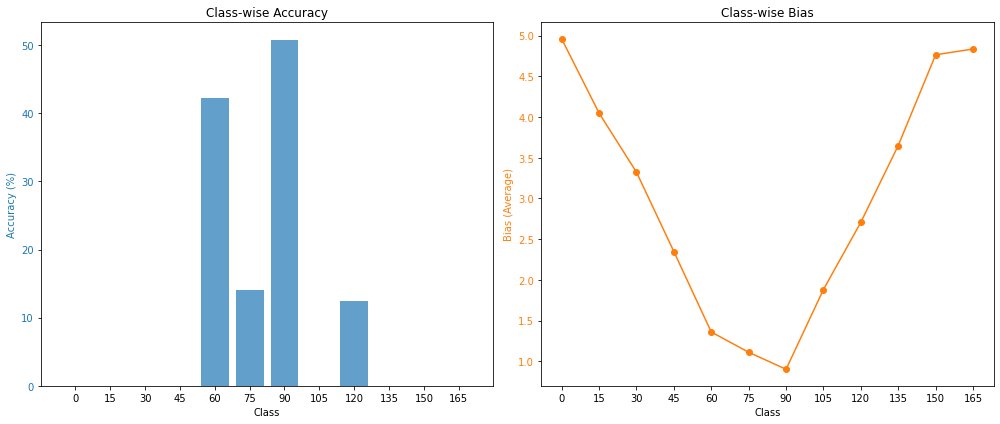

In [23]:
# end-to-end 0 rnn
avg_loss, accuracy, class_accuracy, class_bias = rsl
plot_class_metrics(class_accuracy, class_bias)

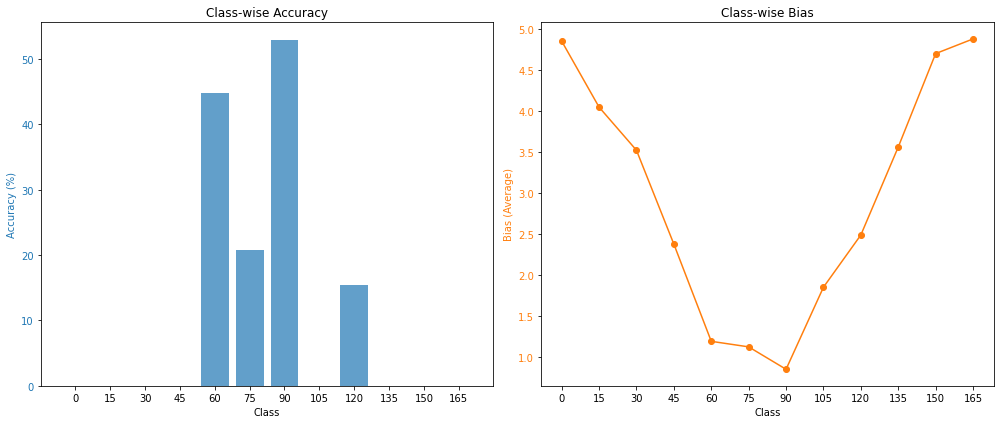

In [25]:
# end-to-end 10 rnn
avg_loss, accuracy, class_accuracy, class_bias = rsl
plot_class_metrics(class_accuracy, class_bias)

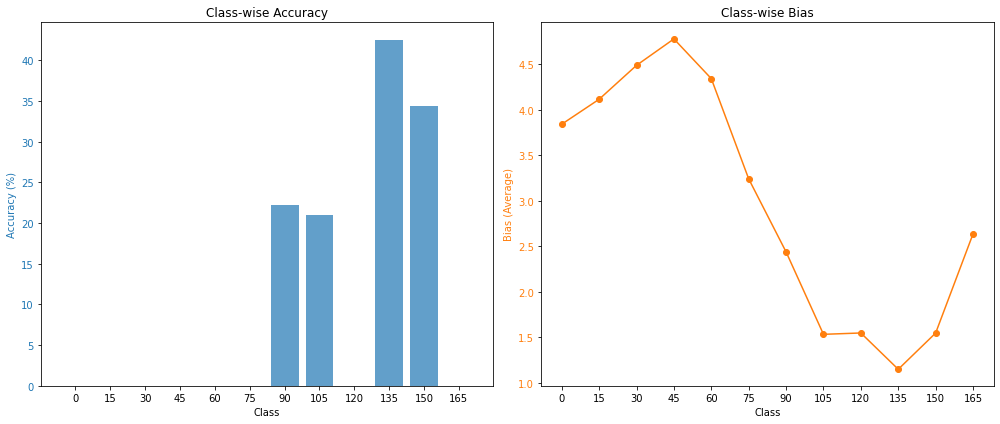

In [29]:
# pre-trained 0 ctrnn
avg_loss, accuracy, class_accuracy, class_bias = rsl
plot_class_metrics(class_accuracy, class_bias)

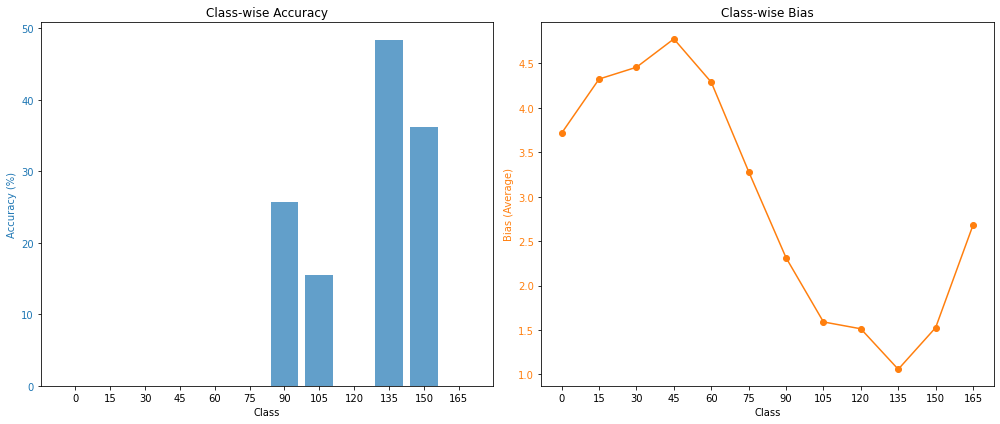

In [31]:
# pre-trained 10 ctrnn
avg_loss, accuracy, class_accuracy, class_bias = rsl
plot_class_metrics(class_accuracy, class_bias)

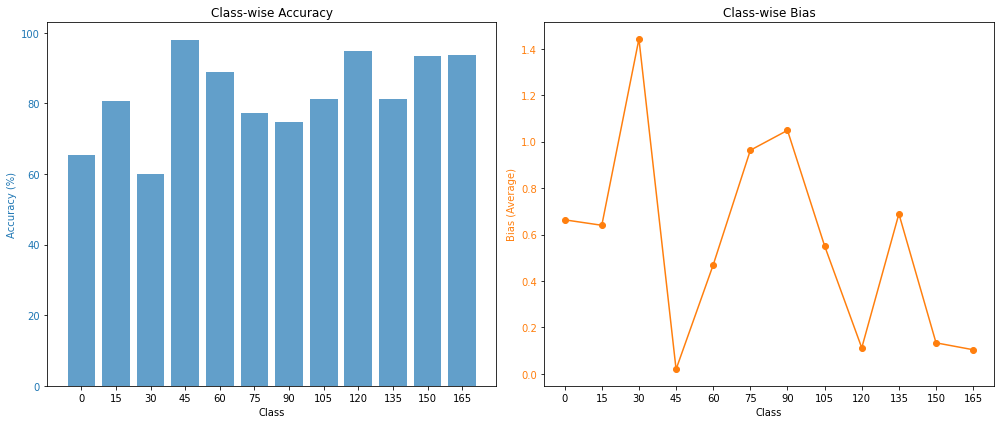

In [39]:
# end-to-end 10 ctrnn
avg_loss, accuracy, class_accuracy, class_bias = rsl
plot_class_metrics(class_accuracy, class_bias)

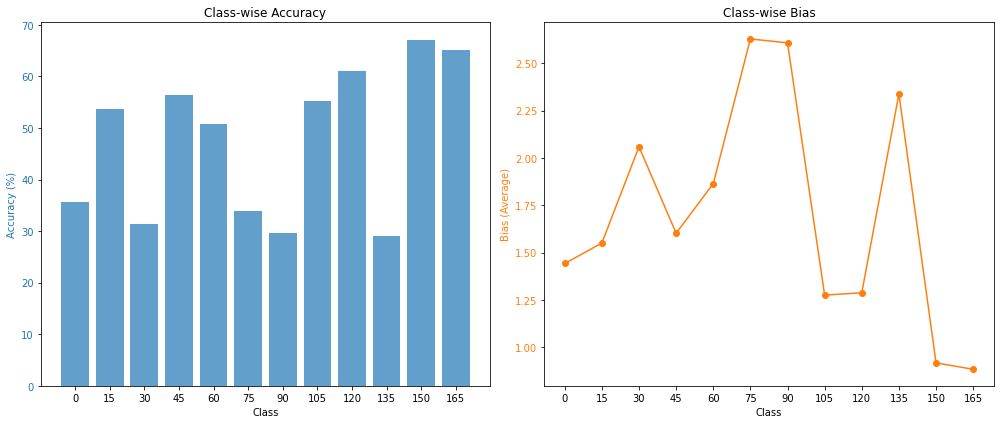

In [37]:
# end-to-end 0 ctrnn
avg_loss, accuracy, class_accuracy, class_bias = rsl
plot_class_metrics(class_accuracy, class_bias)

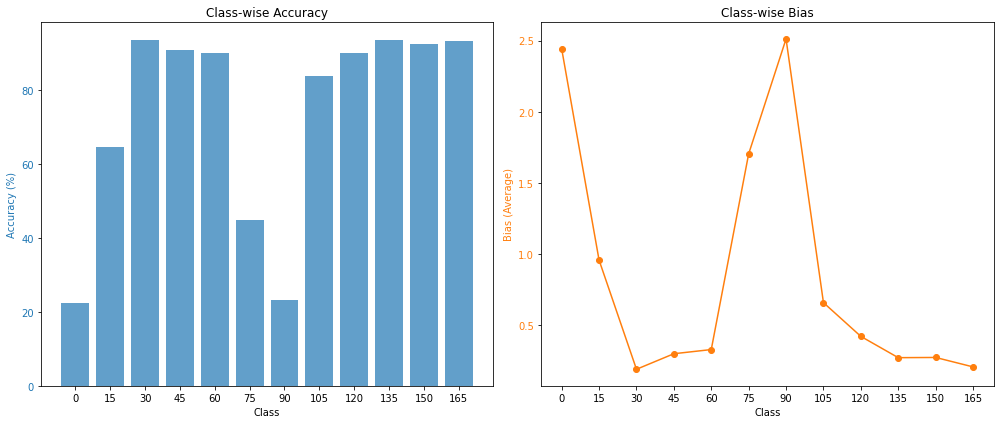

In [ ]:
# pretrained 10
avg_loss, accuracy, class_accuracy, class_bias = rsl
plot_class_metrics(class_accuracy, class_bias)

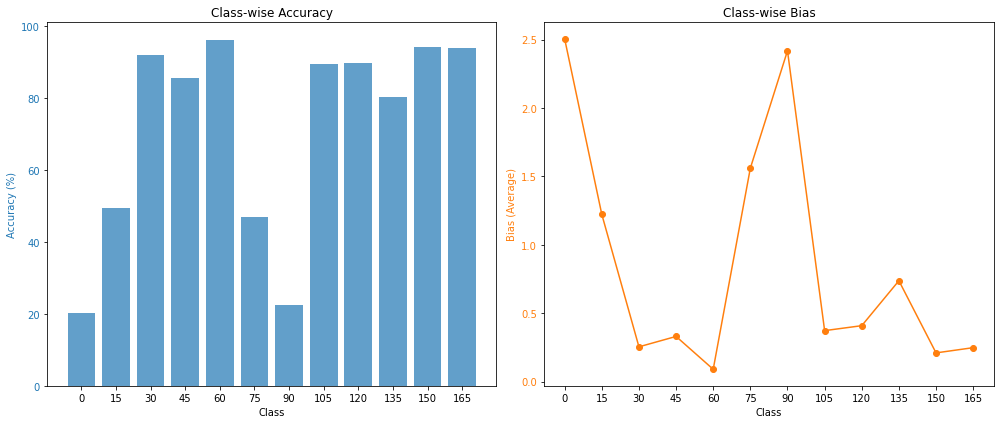

In [ ]:
# pretrained 0
avg_loss, accuracy, class_accuracy, class_bias = rsl
plot_class_metrics(class_accuracy, class_bias)

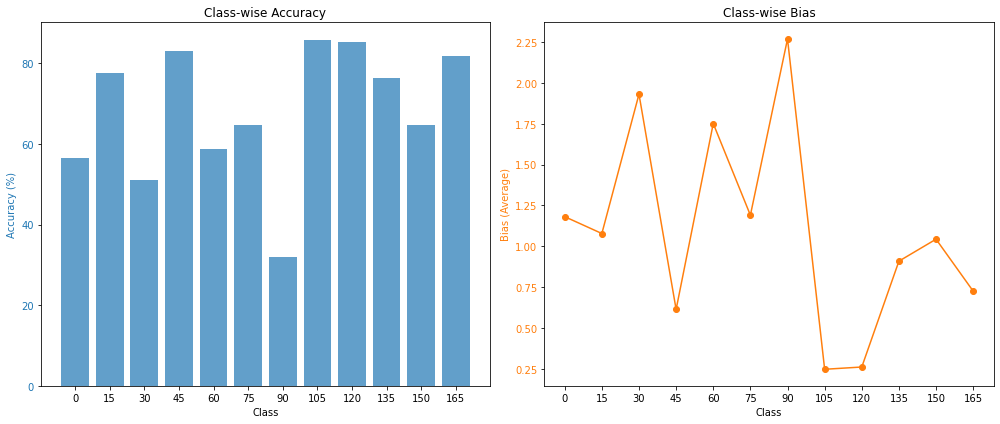

In [23]:
# end-to-end 10
avg_loss, accuracy, class_accuracy, class_bias = rsl
plot_class_metrics(class_accuracy, class_bias)

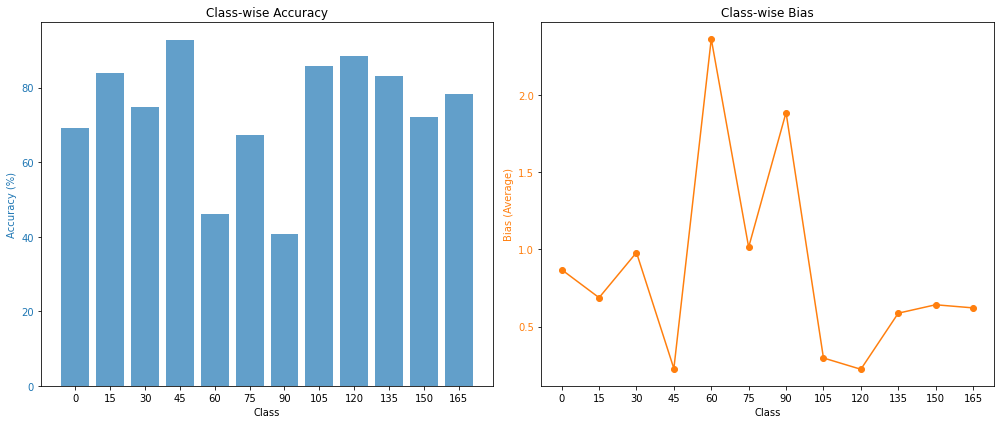

In [21]:
# end-to-end 0
avg_loss, accuracy, class_accuracy, class_bias = rsl
plot_class_metrics(class_accuracy, class_bias)

In [19]:
def test(model, test_loader, delay_num=0):
    model.eval()  # Set the model to evaluation mode
    criterion = nn.CrossEntropyLoss()  # Define the loss function

    running_loss = 0.0
    total_test = 0
    correct_test = 0

    with torch.no_grad():  # Disable gradient computation for testing
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            hidden = None
            for i in range(30):
                if 10 + delay_num <= i < 20:
                    continue
                image = images[:, i]
                outputs, hidden = model(image, hidden)
            
            # Calculate the loss
            loss = criterion(outputs, labels.long())
            running_loss += loss.item()

            # Calculate accuracy
            predicted = outputs.argmax(-1)
            total_test += images.shape[0]
            # correct_test += (predicted == labels).sum().item()
            diff = torch.abs(predicted - labels)
            cyclic_diff = torch.minimum(diff, 12 - diff)
            correct_test += ((cyclic_diff == 0).float() * 1.0 + (cyclic_diff == 1).float() * 0.8 + (cyclic_diff == 2).float() * 0.6 + (cyclic_diff == 3).float() * 0.4 + (cyclic_diff == 4).float() * 0.2).sum().item()

    # Calculate average loss and accuracy
    avg_loss = running_loss / total_test
    accuracy = 100 * correct_test / total_test
    
    print(predicted, labels.int(), sep="\n")        

    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy


In [25]:
rsl = test(model, loader_for_one)

tensor([ 9,  2,  1,  6,  8,  1,  6,  9,  7,  7,  1,  5,  1,  1,  8,  4,  8,  1,
         2,  2,  5,  5,  8,  5,  7,  8,  8,  5,  1,  6, 11,  9,  1,  1,  6,  1,
         2,  8,  5,  8,  5,  8,  8,  1, 11,  8,  2,  8,  8,  8,  0,  9,  2,  8,
         8,  1,  8,  5,  4,  8,  1,  8,  7,  1,  5,  8,  2,  8,  4,  8,  8,  8,
         6,  6,  4,  8,  1,  9,  1,  1,  8,  8,  8,  1,  0,  5,  7,  8],
       device='cuda:0')
tensor([ 9,  2,  6,  6,  8,  1,  6,  9,  7,  7,  1,  5,  7,  1,  0,  4,  0,  1,
         1,  2,  5, 11, 11,  5,  7,  8,  8,  5,  5,  6, 11,  9,  1,  1,  6,  1,
         2,  3,  5, 11,  0, 11, 11,  3, 11,  8, 11,  8,  9,  8,  0,  9,  2,  8,
         8,  1,  3,  5,  4,  6,  6,  6,  7,  1, 11,  9,  1, 11,  4, 11,  0,  8,
         6,  6,  4,  0,  1,  9,  1,  0,  8,  3,  7,  3,  0,  5,  7,  8],
       device='cuda:0', dtype=torch.int32)
Test Loss: 0.0105, Test Accuracy: 77.30%


In [26]:
rsl = test(model, loader_for_one, delay_num=5)

tensor([ 9,  2,  1,  6,  8,  1,  6,  9,  7,  7,  1,  5,  1,  1,  8,  4,  8,  1,
         1,  2,  5,  5,  8,  1,  7,  8,  8,  5,  1,  6, 11,  9,  1,  1,  6,  1,
         2,  8,  5,  7,  5,  8,  8,  1, 11,  8,  2,  8,  8,  8,  0,  9,  2,  8,
         8,  1,  8,  1,  4,  8,  1,  8,  7,  1,  5,  8,  1,  7,  4,  8,  8,  8,
         6,  6,  4,  8,  1,  9,  1,  1,  8,  8,  8,  1,  0,  1,  7,  8],
       device='cuda:0')
tensor([ 9,  2,  6,  6,  8,  1,  6,  9,  7,  7,  1,  5,  7,  1,  0,  4,  0,  1,
         1,  2,  5, 11, 11,  5,  7,  8,  8,  5,  5,  6, 11,  9,  1,  1,  6,  1,
         2,  3,  5, 11,  0, 11, 11,  3, 11,  8, 11,  8,  9,  8,  0,  9,  2,  8,
         8,  1,  3,  5,  4,  6,  6,  6,  7,  1, 11,  9,  1, 11,  4, 11,  0,  8,
         6,  6,  4,  0,  1,  9,  1,  0,  8,  3,  7,  3,  0,  5,  7,  8],
       device='cuda:0', dtype=torch.int32)
Test Loss: 0.0110, Test Accuracy: 75.77%


In [27]:
rsl = test(model, loader_for_one, delay_num=10)

tensor([ 9,  2,  1,  6,  8,  1,  6,  9,  7,  7,  1,  5,  1,  1,  8,  1,  8,  1,
         1,  2,  5,  5,  8,  1,  7,  8,  8,  5,  1,  6, 11,  9,  1,  1,  6,  1,
         2,  8,  5,  7,  5,  8,  8,  1, 11,  8,  2,  8,  8,  8,  0,  9,  2,  8,
         8,  1,  8,  1,  4,  8,  1,  8,  7,  1,  5,  9,  1,  7,  4,  8,  1,  8,
         6,  6,  4,  8,  1,  9,  1,  1,  8,  8,  7,  1,  0,  1,  7,  8],
       device='cuda:0')
tensor([ 9,  2,  6,  6,  8,  1,  6,  9,  7,  7,  1,  5,  7,  1,  0,  4,  0,  1,
         1,  2,  5, 11, 11,  5,  7,  8,  8,  5,  5,  6, 11,  9,  1,  1,  6,  1,
         2,  3,  5, 11,  0, 11, 11,  3, 11,  8, 11,  8,  9,  8,  0,  9,  2,  8,
         8,  1,  3,  5,  4,  6,  6,  6,  7,  1, 11,  9,  1, 11,  4, 11,  0,  8,
         6,  6,  4,  0,  1,  9,  1,  0,  8,  3,  7,  3,  0,  5,  7,  8],
       device='cuda:0', dtype=torch.int32)
Test Loss: 0.0115, Test Accuracy: 76.47%


In [29]:
rsl = test(model, loader_for_eight)

tensor([ 0,  4,  3,  8,  2,  9,  8, 11,  8,  8,  6,  8,  2,  8,  6,  7,  2,  8,
        11,  8,  4,  2, 11,  7, 10,  8,  8,  6,  7,  5,  6,  2,  7,  2,  9,  2,
         8,  8,  9,  1,  4,  1,  7,  4,  6,  1,  2,  2, 11,  8, 11,  2,  1,  8,
         2,  8,  2,  8,  6,  4,  6,  2,  2,  8,  7,  2,  6,  8,  2,  8, 11, 11,
         1,  9,  8,  8,  8,  9,  8,  7,  8,  2,  7,  8,  1,  2,  2,  1],
       device='cuda:0')
tensor([ 0,  0,  3,  8,  2,  9,  8, 11, 10,  8,  5,  8,  5,  4,  3,  6,  9,  3,
         3,  9,  4,  2, 11,  9, 10,  6,  8,  6,  7,  5,  6,  3,  7,  2,  4,  2,
         7,  3,  9,  1,  4,  2,  5,  4,  6,  1,  0,  7, 11,  8, 11,  3, 11,  4,
         2,  4,  6,  1,  6,  4,  6,  2,  7,  3,  7,  0,  6,  8,  8,  8, 10,  6,
         1,  6,  3,  4,  0,  9, 10,  7,  5,  5,  7, 11,  1,  0,  3,  1],
       device='cuda:0', dtype=torch.int32)
Test Loss: 0.0199, Test Accuracy: 66.27%


In [30]:
rsl = test(model, loader_for_eight, delay_num=5)

tensor([ 0,  4,  3,  8,  2,  9,  8, 11,  1,  8,  6,  8,  2,  8,  6,  7,  2,  8,
        11,  8,  4,  2, 11,  7, 10,  8,  8,  6,  7,  5,  6,  2,  7,  2,  9,  2,
         7,  8,  9,  1,  4,  1,  7,  4,  6,  1,  2,  2, 11,  8, 11,  2,  1,  8,
         2,  8,  2,  8,  6,  8,  6,  2,  2,  8,  7,  2,  6,  8,  2,  8, 11, 11,
         1,  9,  8,  8,  8,  9,  8,  7,  8,  2,  7,  8,  1,  2,  2,  1],
       device='cuda:0')
tensor([ 0,  0,  3,  8,  2,  9,  8, 11, 10,  8,  5,  8,  5,  4,  3,  6,  9,  3,
         3,  9,  4,  2, 11,  9, 10,  6,  8,  6,  7,  5,  6,  3,  7,  2,  4,  2,
         7,  3,  9,  1,  4,  2,  5,  4,  6,  1,  0,  7, 11,  8, 11,  3, 11,  4,
         2,  4,  6,  1,  6,  4,  6,  2,  7,  3,  7,  0,  6,  8,  8,  8, 10,  6,
         1,  6,  3,  4,  0,  9, 10,  7,  5,  5,  7, 11,  1,  0,  3,  1],
       device='cuda:0', dtype=torch.int32)
Test Loss: 0.0203, Test Accuracy: 65.43%


In [31]:
rsl = test(model, loader_for_eight, delay_num=10)

tensor([ 0,  4,  2,  8,  2,  9,  8, 11,  1,  8,  6,  8,  2,  8,  7,  7,  2,  8,
        11,  8,  4,  2, 11,  7, 10,  7,  8,  6,  7,  5,  6,  2,  7,  2,  9,  2,
         7,  8,  9,  1,  4,  1,  7,  4,  6,  1,  2,  2, 11,  8, 11,  2,  1,  8,
         2,  8,  2,  1,  7,  8,  6,  2,  2,  8,  7,  2,  6,  8,  2,  8, 11, 11,
         1,  9,  8,  4,  8,  9,  8,  1,  8,  2,  7,  8,  1,  2,  2,  1],
       device='cuda:0')
tensor([ 0,  0,  3,  8,  2,  9,  8, 11, 10,  8,  5,  8,  5,  4,  3,  6,  9,  3,
         3,  9,  4,  2, 11,  9, 10,  6,  8,  6,  7,  5,  6,  3,  7,  2,  4,  2,
         7,  3,  9,  1,  4,  2,  5,  4,  6,  1,  0,  7, 11,  8, 11,  3, 11,  4,
         2,  4,  6,  1,  6,  4,  6,  2,  7,  3,  7,  0,  6,  8,  8,  8, 10,  6,
         1,  6,  3,  4,  0,  9, 10,  7,  5,  5,  7, 11,  1,  0,  3,  1],
       device='cuda:0', dtype=torch.int32)
Test Loss: 0.0202, Test Accuracy: 65.77%


In [53]:
# with noise wholistic but on one
rsl = test(model, test_loader, delay_num=10)

tensor([ 5,  3,  3,  3,  5,  5,  5,  5,  5,  5,  5,  3,  5,  5,  3,  3,  3,  5,
         5,  3,  5, 11,  5,  3,  5,  5,  5,  3,  3,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  3,  5,  5,  5,  3,  5,  5,  3,  5,  5,  5,  5,
         5,  5,  8,  3,  5,  5,  5,  5,  3,  5, 11,  5,  5,  5,  5,  5,  5,  5],
       device='cuda:0')
tensor([ 1,  6,  2,  2,  8,  7,  3, 11, 11,  4,  0,  2,  4,  0,  2,  3,  2,  7,
         4,  2,  3, 10,  1,  2,  7,  5,  8,  3,  3, 11,  5,  5,  9,  5,  7,  7,
         8, 11,  3,  6,  5,  5,  2,  4, 11,  5,  3,  8,  1,  2,  6,  0,  9, 11,
        11,  9,  8,  1,  1,  2,  5,  5,  3, 11,  8,  5,  7,  8,  0,  9,  7, 11],
       device='cuda:0', dtype=torch.int32)
Test Loss: 0.0274, Test Accuracy: 46.10%


In [51]:
# with noise wholistic but on eight
rsl = test(model, test_loader, delay_num=10)

tensor([11,  5,  3,  5,  5,  5,  5,  8,  5,  3,  8,  5,  5,  3,  5,  5,  5,  5,
         5,  5,  3,  5,  3,  5,  5,  5,  5, 10,  5, 10,  5,  5,  5,  5,  5,  5,
         5,  8,  8,  3,  5,  5,  5,  5,  5,  5,  5,  5,  5,  3,  5, 10, 10,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 10,  5,  2,  5,  5,  5,  5,  5],
       device='cuda:0')
tensor([ 2,  2,  0,  1,  0,  6, 10,  0,  4,  1, 10,  4,  1, 11,  5,  0,  8,  2,
         9,  2,  1,  3,  4,  6,  2,  1,  9,  0,  5,  4,  0, 10,  0, 11,  4,  8,
         6,  3, 11,  2,  2,  8,  4,  2,  8,  6, 10,  5,  0, 11,  1,  1,  2,  0,
        11,  1,  5, 11, 11, 10, 11,  4,  4,  4,  4,  3,  5,  0,  6, 10,  3,  3],
       device='cuda:0', dtype=torch.int32)
Test Loss: 0.0321, Test Accuracy: 38.70%


In [20]:
# with noise
rsl = test(model, test_loader)

tensor([ 5,  8,  2,  1,  2, 10,  8,  1,  2,  1,  2,  8,  2,  8,  2,  8,  9,  8,
        10,  2,  6,  1,  6,  5,  8,  4,  5,  8,  8,  6,  5,  8],
       device='cuda:0')
tensor([ 3,  8,  0,  3,  2,  3,  8,  3,  4,  3,  5,  5,  6,  0,  2,  1,  6,  3,
        10,  0,  3,  1,  6, 11,  3,  8,  0, 11,  8,  6,  5,  8],
       device='cuda:0', dtype=torch.int32)
Test Loss: 0.0253, Test Accuracy: 60.60%


In [21]:
# with noise
rsl = test(model, test_loader, delay_num=5)

tensor([ 5,  8,  2,  1,  2, 10,  8,  1,  1,  1,  2,  8,  2,  8,  2,  8,  9,  8,
        10,  2,  6,  1,  6,  5,  8,  4,  5,  8,  8,  6,  5,  8],
       device='cuda:0')
tensor([ 3,  8,  0,  3,  2,  3,  8,  3,  4,  3,  5,  5,  6,  0,  2,  1,  6,  3,
        10,  0,  3,  1,  6, 11,  3,  8,  0, 11,  8,  6,  5,  8],
       device='cuda:0', dtype=torch.int32)
Test Loss: 0.0260, Test Accuracy: 59.68%


In [22]:
# with noise
rsl = test(model, test_loader, delay_num=10)

tensor([ 5,  8,  2,  1,  2, 10,  8,  1,  1,  1,  2,  8,  2,  8,  2,  8,  9,  8,
        10,  2,  6,  1,  6,  5,  8,  4,  5,  8,  8,  6,  5,  8],
       device='cuda:0')
tensor([ 3,  8,  0,  3,  2,  3,  8,  3,  4,  3,  5,  5,  6,  0,  2,  1,  6,  3,
        10,  0,  3,  1,  6, 11,  3,  8,  0, 11,  8,  6,  5,  8],
       device='cuda:0', dtype=torch.int32)
Test Loss: 0.0261, Test Accuracy: 59.33%


In [ ]:
# with noise
rsl = test(model, test_loader)

tensor([ 5,  8,  2,  1,  2, 10,  8,  1,  2,  1,  2,  8,  2,  8,  2,  8,  9,  8,
        10,  2,  6,  1,  6,  5,  8,  4,  5,  8,  8,  6,  5,  8],
       device='cuda:0')
tensor([ 3,  8,  0,  3,  2,  3,  8,  3,  4,  3,  5,  5,  6,  0,  2,  1,  6,  3,
        10,  0,  3,  1,  6, 11,  3,  8,  0, 11,  8,  6,  5,  8],
       device='cuda:0', dtype=torch.int32)
Test Loss: 0.0253, Test Accuracy: 37.25%


In [ ]:
# with noise
rsl = test(model, test_loader, delay_num=5)

tensor([ 5,  8,  2,  1,  2, 10,  8,  1,  1,  1,  2,  8,  2,  8,  2,  8,  9,  8,
        10,  2,  6,  1,  6,  5,  8,  4,  5,  8,  8,  6,  5,  8],
       device='cuda:0')
tensor([ 3,  8,  0,  3,  2,  3,  8,  3,  4,  3,  5,  5,  6,  0,  2,  1,  6,  3,
        10,  0,  3,  1,  6, 11,  3,  8,  0, 11,  8,  6,  5,  8],
       device='cuda:0', dtype=torch.int32)
Test Loss: 0.0260, Test Accuracy: 36.50%


In [11]:
# with noise
rsl = test(model, test_loader, delay_num=10)

tensor([ 5,  8,  2,  1,  2, 10,  8,  1,  1,  1,  2,  8,  2,  8,  2,  8,  9,  8,
        10,  2,  6,  1,  6,  5,  8,  4,  5,  8,  8,  6,  5,  8],
       device='cuda:0')
tensor([ 3,  8,  0,  3,  2,  3,  8,  3,  4,  3,  5,  5,  6,  0,  2,  1,  6,  3,
        10,  0,  3,  1,  6, 11,  3,  8,  0, 11,  8,  6,  5,  8],
       device='cuda:0', dtype=torch.int32)
Test Loss: 0.0261, Test Accuracy: 36.38%


In [ ]:
# no noise
rsl = test(model, test_loader)

tensor([ 8, 10,  3,  6,  4,  3,  6,  8,  4,  6,  9,  5,  5,  8,  8,  8,  5,  2,
         8,  3, 10,  1,  2,  4,  5,  4,  6,  7,  4, 11,  3,  7],
       device='cuda:0')
tensor([ 1, 10,  7,  6,  0,  6,  9,  4,  8,  7, 10,  1,  9,  0,  9,  6,  6,  2,
         7,  0,  4,  1, 11,  4,  5,  3,  6,  7, 11,  4,  3,  7],
       device='cuda:0', dtype=torch.int32)
Test Loss: 0.0179, Test Accuracy: 41.88%


In [35]:
rsl = test(model, train_loader)

tensor([ 2,  2,  2, 11,  2,  2,  2,  2, 11,  2,  2,  8,  2,  8,  2,  2,  2,  2,
         8,  2,  8,  8,  2,  2,  2, 11,  2,  2,  8,  2, 11,  2,  8,  2, 11,  2,
         2,  2,  8,  2,  8,  2,  2,  8,  2,  8,  2,  2,  8,  2,  8,  2,  2,  2,
        11, 11, 11,  2,  8,  2,  2,  8,  2,  8,  2,  2,  8,  2, 11,  2, 11,  8,
         2, 11,  2,  2,  2,  2,  2,  2,  2,  8,  8,  8,  2,  2, 11,  2,  2,  8,
         2,  2,  2,  2,  2,  2], device='cuda:0')
tensor([ 9,  1,  8,  9,  9, 11,  3,  2,  4,  4,  4,  0,  5, 11,  0, 10,  0,  2,
         6, 11,  2,  3,  6, 10,  3, 11,  1,  2,  0,  7,  7,  3, 11,  3,  5,  9,
         3, 10,  4,  3,  0,  1,  2,  7, 11,  8,  7,  7,  8,  4, 11,  3,  6,  5,
        11,  7,  3,  1,  6,  0,  7,  7,  8,  9,  2,  6,  4, 11,  7,  9,  4,  2,
         7, 10, 11,  5, 11, 11,  4,  0,  9,  1,  0, 10,  3,  8, 10, 10,  0,  4,
         7,  8,  0,  0,  6, 11], device='cuda:0', dtype=torch.int32)
Test Loss: 0.0196, Test Accuracy: 9.38%
